# 5. Customer / Stakeholder Acceptance

Tahap ini berfokus pada:
- Memvalidasi apakah model yang dideploy benar-benar menjawab kebutuhan bisnis.
- Menganalisis error untuk memahami kasus di mana model kurang akurat.
- Menyiapkan materi hand-off ke tim operasional / produk.

Notebook ini akan:
1. Memuat dataset bersih dan model yang sudah dideploy.
2. Menghitung metrik kinerja model pada data uji.
3. Melakukan analisis error sederhana.
4. Menyusun poin-poin acceptance dan hand-off.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## 5.1 Load Dataset dan Model

In [4]:
# Load dataset bersih
DATA_PATH = '../Dataset/UsedCarsSA_Clean.csv'
df_clean = pd.read_csv(DATA_PATH)

# Pastikan feature engineering yang digunakan di training tersedia
if 'Car_Age' not in df_clean.columns and 'Year' in df_clean.columns:
    df_clean['Car_Age'] = 2025 - df_clean['Year']

# Definisikan target dan fitur
target = 'Price'
X = df_clean.drop(columns=[target])
y = df_clean[target]

# Split data (konsisten dengan modeling)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Load model terbaik dari deployment
MODEL_PATH = '../Model/xgb_tuned_mae11198_20251218.joblib'
model = joblib.load(MODEL_PATH)

print('Data dan model berhasil dimuat.')
X_test.head()

Data dan model berhasil dimuat.


,Make,Type,Year,Origin,Color,Options,Engine_Size,Fuel_Type,Gear_Type,Mileage,Region,Car_Age,Mileage_per_Year
2895,Toyota,Land Cruiser,2006,Saudi,Another Color,Full,4.5,Gas,Automatic,215000,Dammam,19,10750.000000
4430,Toyota,Corolla,2012,Gulf Arabic,White,Semi Full,1.6,Gas,Manual,185000,Al-Medina,13,13214.285714
3618,Kia,Cerato,2020,Saudi,Grey,Standard,1.6,Gas,Automatic,36000,Riyadh,5,6000.000000
763,Toyota,Corolla,2016,Saudi,White,Standard,1.6,Gas,Automatic,142478,Riyadh,9,14247.800000
4392,Ford,Ranger,2015,Saudi,Black,Full,3.2,Diesel,Manual,145000,Aseer,10,13181.818182


## 5.2 Evaluasi Ulang Metrik Kinerja

In [5]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    nonzero = y_true != 0
    return np.mean(np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero])) * 100

# Prediksi data uji
y_pred = model.predict(X_test)

# Hitung metrik
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE  : {mae:,.2f}')
print(f'RMSE : {rmse:,.2f}')
print(f'MAPE : {mape:,.2f}%')
print(f'R^2  : {r2:.3f}')

MAE  : 11,197.75
RMSE : 18,731.86
MAPE : 111.09%
R^2  : 0.785


## 5.3 Analisis Error

In [6]:
error_df = X_test.copy()
error_df['Actual'] = y_test.values
error_df['Predicted'] = y_pred
error_df['Absolute_Error'] = (error_df['Actual'] - error_df['Predicted']).abs()
error_df['APE'] = error_df['Absolute_Error'] / error_df['Actual'] * 100

error_df.sort_values('Absolute_Error', ascending=False).head(10)

,Make,Type,Year,Origin,Color,Options,Engine_Size,Fuel_Type,Gear_Type,Mileage,Region,Car_Age,Mileage_per_Year,Actual,Predicted,Absolute_Error,APE
4428,Jeep,Grand Cherokee,2017,Saudi,Silver,Full,3.6,Gas,Automatic,13300,Najran,8,1477.777778,3100.0,117873.804688,114773.804688,3702.380796
4726,Toyota,Avalon,2019,Gulf Arabic,Grey,Standard,3.2,Gas,Automatic,44000,Riyadh,6,6285.714286,2093.0,114528.265625,112435.265625,5371.966824
2519,Hyundai,Senta fe,2019,Other,White,Full,3.5,Gas,Automatic,10000,Hafar Al-Batin,6,1428.571429,2357.0,106857.593750,104500.593750,4433.627227
4246,Dodge,Durango,2019,Saudi,Black,Full,3.6,Gas,Automatic,95000,Riyadh,6,13571.428571,2820.0,106100.687500,103280.687500,3662.435727
2269,Bentley,Flying Spur,2010,Saudi,Another Color,Full,5.0,Gas,Automatic,58000,Dammam,15,3625.000000,175000.0,77733.578125,97266.421875,55.580813
4685,Dodge,Charger,2018,Saudi,Silver,Semi Full,1.6,Gas,Automatic,5000,Taef,7,625.000000,125000.0,30392.599609,94607.400391,75.685920
3741,Mazda,6,2018,Saudi,Silver,Full,2.5,Gas,Automatic,76000,Makkah,7,9500.000000,1640.0,93118.304688,91478.304688,5577.945408
4354,Hyundai,Sonata,2020,Saudi,White,Full,2.5,Gas,Automatic,17000,Jeddah,5,2833.333333,1430.0,92824.343750,91394.343750,6391.212850
2223,Toyota,Rav4,2018,Saudi,White,Full,2.5,Gas,Automatic,90000,Tabouk,7,11250.000000,1300.0,90192.843750,88892.843750,6837.911058
2191,Ford,Mustang,2016,Saudi,Silver,Standard,5.0,Gas,Automatic,184000,Jubail,9,18400.000000,3049.0,89061.812500,86012.812500,2821.017137


### Distribusi Error

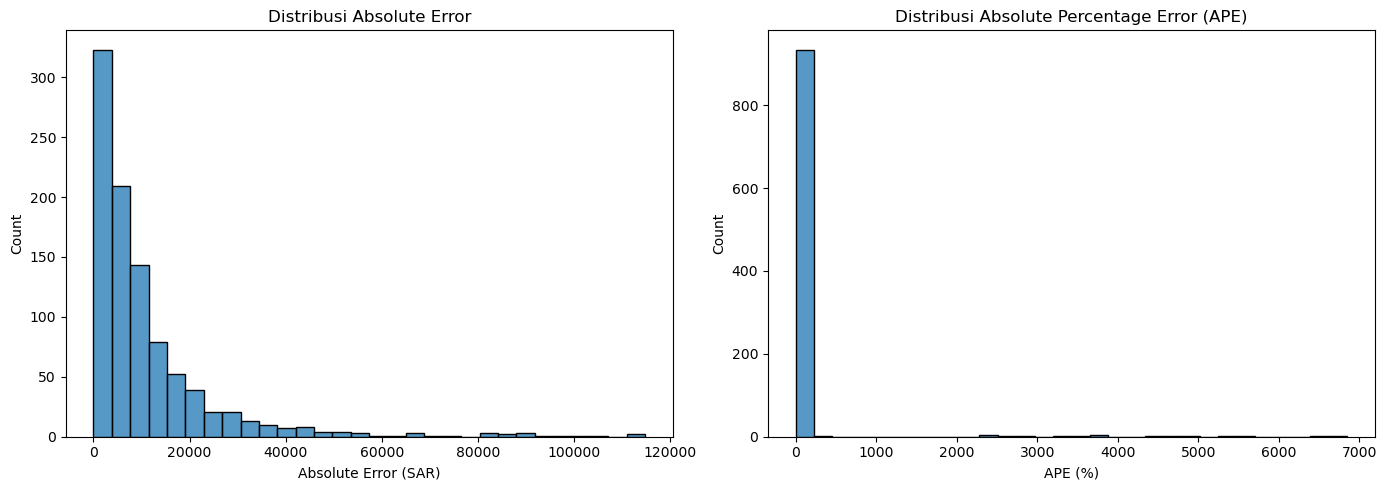

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(error_df['Absolute_Error'], bins=30, ax=axes[0])
axes[0].set_title('Distribusi Absolute Error')
axes[0].set_xlabel('Absolute Error (SAR)')

sns.histplot(error_df['APE'], bins=30, ax=axes[1])
axes[1].set_title('Distribusi Absolute Percentage Error (APE)')
axes[1].set_xlabel('APE (%)')

plt.tight_layout()
plt.show()

### Error per Segmen (Type dan Region)

In [8]:
if 'Type' in error_df.columns:
    type_error = error_df.groupby('Type')['APE'].mean().sort_values()
    print('Rata-rata APE per Type (5 terbaik):')
    display(type_error.head(5))
    print('\nRata-rata APE per Type (5 terburuk):')
    display(type_error.tail(5))

if 'Region' in error_df.columns:
    region_error = error_df.groupby('Region')['APE'].mean().sort_values()
    print('\nRata-rata APE per Region (5 terbaik):')
    display(region_error.head(5))
    print('\nRata-rata APE per Region (5 terburuk):')
    display(region_error.tail(5))

Rata-rata APE per Type (5 terbaik):


Type
Terrain       1.169509
CT4           2.117923
CT6           2.141094
Echo Sport    2.775314
Prestige      3.251452
Name: APE, dtype: float64


Rata-rata APE per Type (5 terburuk):


Type
Avalon      778.440393
Attrage    1157.123556
Rav4       1716.227841
Passat     2712.701330
Megane     6847.026699
Name: APE, dtype: float64


Rata-rata APE per Region (5 terbaik):


Region
Qurayyat     2.880287
Yanbu       10.900466
Al-Namas    13.664384
Qassim      14.142606
Al-Ahsa     14.172062
Name: APE, dtype: float64


Rata-rata APE per Region (5 terburuk):


Region
Makkah             529.129225
Tabouk             575.437071
Hafar Al-Batin     896.726727
Arar              1876.322806
Najran            2324.466237
Name: APE, dtype: float64

## 5.4 Poin Diskusi dengan Stakeholder

1. **Kinerja Model (Overall)**
   - MAE dan MAPE dibandingkan dengan target bisnis.
   - R^2 sebagai indikator tambahan daya jelaskan model.

2. **Kinerja per Segmen**
   - Identifikasi Type dan Region dengan error rendah dan tinggi.

3. **Kasus Error Besar**
   - Mobil langka, luxury, atau kondisi khusus.

4. **Rekomendasi Penggunaan**
   - Model sebagai alat bantu rekomendasi harga, bukan keputusan final.

## 5.5 Hand-off dan Rencana Lanjutan

Artefak yang diserahkan:
- File model (`.joblib`)
- Notebook modeling dan deployment
- Notebook acceptance ini

Rencana iterasi berikutnya:
- Monitoring performa
- Penambahan fitur
- Retraining berkala

Dengan ini, satu siklus TDSP dianggap selesai.